# Random Forest S&P 500 Directional Predictor

This notebook implements a machine learning model to predict whether the S&P 500 index will go up or down the next day.

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

## 1. Load and Explore the Data

Let's load the S&P 500 index data from the CSV file.

In [5]:
# Load the S&P 500 index data
sp500_index = pd.read_csv('archive/sp500_index.csv')

# Convert the Date column to datetime
sp500_index['Date'] = pd.to_datetime(sp500_index['Date'])

# Set the Date column as the index
sp500_index.set_index('Date', inplace=True)

# Display the first few rows
sp500_index.head()

,S&P500
Date,
2014-12-22,2078.54
2014-12-23,2082.17
2014-12-24,2081.88
2014-12-26,2088.77
2014-12-29,2090.57


<Figure size 1200x600 with 0 Axes>

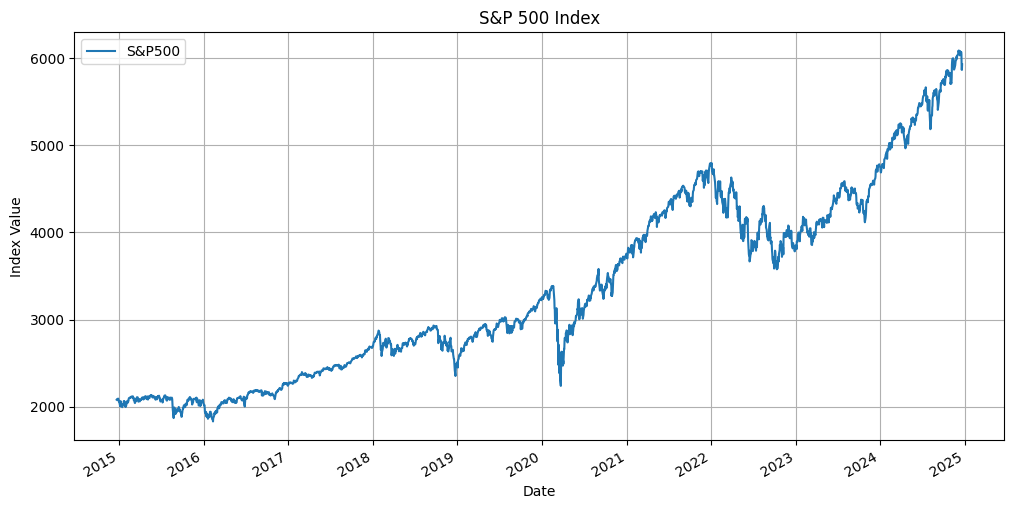

In [6]:
# Plot the S&P 500 index over time
plt.figure(figsize=(12, 6))
sp500_index.plot(title='S&P 500 Index', figsize=(12, 6))
plt.ylabel('Index Value')
plt.grid(True)
plt.show()

## 2. Data Preprocessing

Now, let's create our target variable - whether the index goes up or down the next day.

In [7]:
# Create the target variable: 1 if tomorrow's price is higher, 0 otherwise
sp500_index['Tomorrow'] = sp500_index['S&P500'].shift(-1)
sp500_index['Target'] = (sp500_index['Tomorrow'] > sp500_index['S&P500']).astype(int)

# Display the data with the target variable
sp500_index.head()

,S&P500,Tomorrow,Target
Date,,,
2014-12-22,2078.54,2082.17,1
2014-12-23,2082.17,2081.88,0
2014-12-24,2081.88,2088.77,1
2014-12-26,2088.77,2090.57,1
2014-12-29,2090.57,2080.35,0


## 3. Feature Engineering

Let's create some technical indicators as features to help predict the market direction.

In [8]:
def add_features(df):
    """Add technical indicators and other features to the dataframe"""
    # Create a copy to avoid warnings
    data = df.copy()
    
    # 1. Moving averages
    for window in [5, 10, 20, 50]:
        data[f'MA_{window}'] = data['S&P500'].rolling(window=window).mean()
    
    # 2. Relative price levels
    for window in [5, 10, 20, 50]:
        data[f'Price_Ratio_{window}'] = data['S&P500'] / data[f'MA_{window}']
    
    # 3. Price momentum (percentage change)
    for window in [1, 5, 10]:
        data[f'Momentum_{window}'] = data['S&P500'].pct_change(periods=window)
    
    # 4. Volatility (rolling standard deviation)
    for window in [5, 10, 20]:
        data[f'Volatility_{window}'] = data['S&P500'].rolling(window=window).std()
    
    # 5. RSI (Relative Strength Index)
    delta = data['S&P500'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # 6. Add day of week (potential seasonality)
    data['DayOfWeek'] = data.index.dayofweek
    data['Month'] = data.index.month
    
    return data

In [9]:
# Add features to the data
sp500_with_features = add_features(sp500_index)

# Drop rows with NaN values that resulted from the calculations
sp500_with_features = sp500_with_features.dropna()

# Display the first few rows with the added features
sp500_with_features.head()

,S&P500,Tomorrow,Target,MA_5,MA_10,MA_20,MA_50,Price_Ratio_5,Price_Ratio_10,Price_Ratio_20,Price_Ratio_50,Momentum_1,Momentum_5,Momentum_10,Volatility_5,Volatility_10,Volatility_20,RSI,DayOfWeek,Month
Date,,,,,,,,,,,,,,,,,,,,
2015-03-05,2101.04,2071.26,0,2105.848,2108.928,2093.7035,2062.2242,0.997717,0.996260,1.003504,1.018822,0.001196,-0.004596,0.001712,7.338894,6.108504,21.385850,57.919294,3,3
2015-03-06,2071.26,2079.43,1,2099.200,2105.024,2094.1405,2062.0786,0.986690,0.983960,0.989074,1.004452,-0.014174,-0.015795,-0.018500,17.240726,13.335033,20.796277,37.207915,4,3
2015-03-09,2079.43,2044.16,0,2091.608,2102.001,2095.3385,2062.0238,0.994178,0.989262,0.992408,1.008441,0.003944,-0.017928,-0.014329,15.498025,15.429348,19.069823,40.079704,0,3
2015-03-10,2044.16,2040.24,0,2078.884,2094.869,2095.2095,2061.2694,0.983297,0.975794,0.975635,0.991700,-0.016961,-0.030183,-0.033713,23.135651,23.088782,19.421362,30.171429,1,3
2015-03-11,2040.24,2065.95,1,2067.226,2087.507,2093.7920,2060.2988,0.986946,0.977357,0.974423,0.990264,-0.001918,-0.027777,-0.034827,25.342069,27.647595,22.289316,29.811560,2,3


## 4. Model Training

Let's define a baseline Random Forest model and training approach.

In [10]:
# Define features and target
features = [
    'MA_5', 'MA_10', 'MA_20', 'MA_50',
    'Price_Ratio_5', 'Price_Ratio_10', 'Price_Ratio_20', 'Price_Ratio_50',
    'Momentum_1', 'Momentum_5', 'Momentum_10',
    'Volatility_5', 'Volatility_10', 'Volatility_20',
    'RSI', 'DayOfWeek', 'Month'
]

# Create train-test split (keeping the time order)
train_size = int(len(sp500_with_features) * 0.8)
train_data = sp500_with_features.iloc[:train_size]
test_data = sp500_with_features.iloc[train_size:]

print(f"Training data size: {train_data.shape[0]} days")
print(f"Testing data size: {test_data.shape[0]} days")

Training data size: 1973 days
Testing data size: 494 days


In [11]:
# Create and train the model
model = RandomForestClassifier(n_estimators=100, min_samples_split=30, random_state=42)
model.fit(train_data[features], train_data['Target'])

# Make predictions on the test set
predictions = model.predict(test_data[features])

# Evaluate the model
accuracy = model.score(test_data[features], test_data['Target'])
precision = precision_score(test_data['Target'], predictions)
recall = recall_score(test_data['Target'], predictions)
f1 = f1_score(test_data['Target'], predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.4656
Precision: 0.5448
Recall: 0.2852
F1 Score: 0.3744


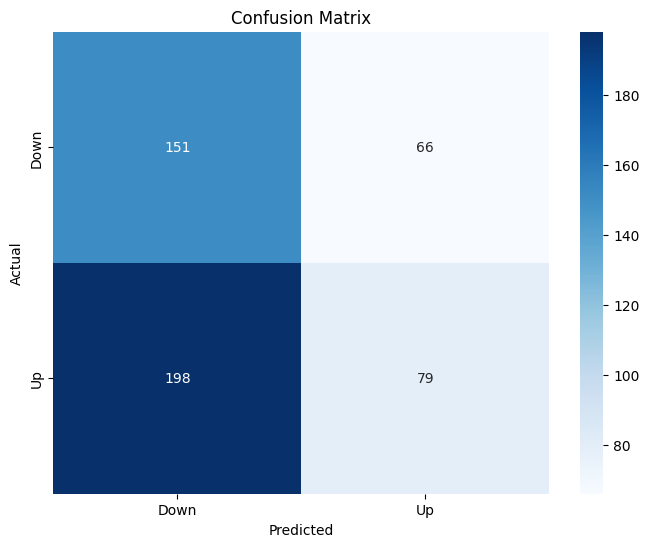

In [12]:
# Create confusion matrix
cm = confusion_matrix(test_data['Target'], predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Down', 'Up'], 
            yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 5. Cross-Validation with Walk-Forward Testing

For time series data, standard cross-validation is not appropriate. Let's implement a walk-forward validation approach.

In [13]:
def predict(train, test, features, model):
    """Train model on training data and predict on test data"""
    model.fit(train[features], train['Target'])
    preds = model.predict(test[features])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

def backtest(data, model, features, start=500, step=250):
    """Walk-forward testing"""
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, features, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [14]:
# Perform walk-forward validation
model = RandomForestClassifier(n_estimators=100, min_samples_split=30, random_state=42)
backtest_predictions = backtest(sp500_with_features, model, features)

# Evaluate the results
backtest_precision = precision_score(backtest_predictions['Target'], backtest_predictions['Predictions'])
backtest_recall = recall_score(backtest_predictions['Target'], backtest_predictions['Predictions'])
backtest_f1 = f1_score(backtest_predictions['Target'], backtest_predictions['Predictions'])

print(f"Backtest Precision: {backtest_precision:.4f}")
print(f"Backtest Recall: {backtest_recall:.4f}")
print(f"Backtest F1 Score: {backtest_f1:.4f}")

Backtest Precision: 0.5430
Backtest Recall: 0.6056
Backtest F1 Score: 0.5726


<Figure size 1400x700 with 0 Axes>

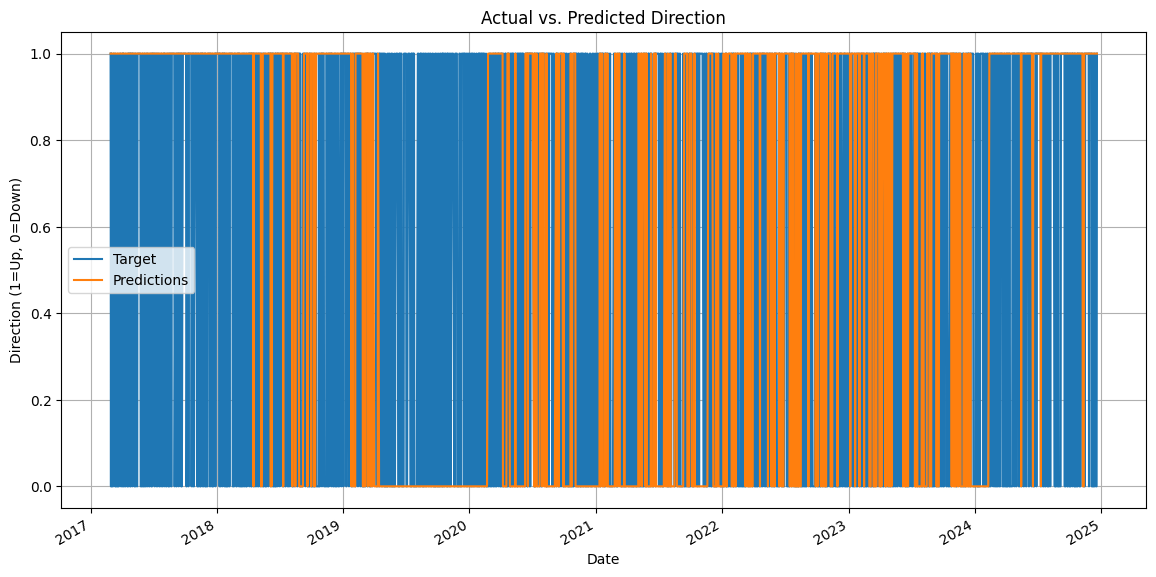

In [15]:
# Visualize the actual vs. predicted values over time
plt.figure(figsize=(14, 7))
backtest_predictions.plot(title='Actual vs. Predicted Direction', figsize=(14, 7))
plt.ylabel('Direction (1=Up, 0=Down)')
plt.grid(True)
plt.show()

## 6. Feature Importance Analysis

Let's examine which features are most important for our prediction task.

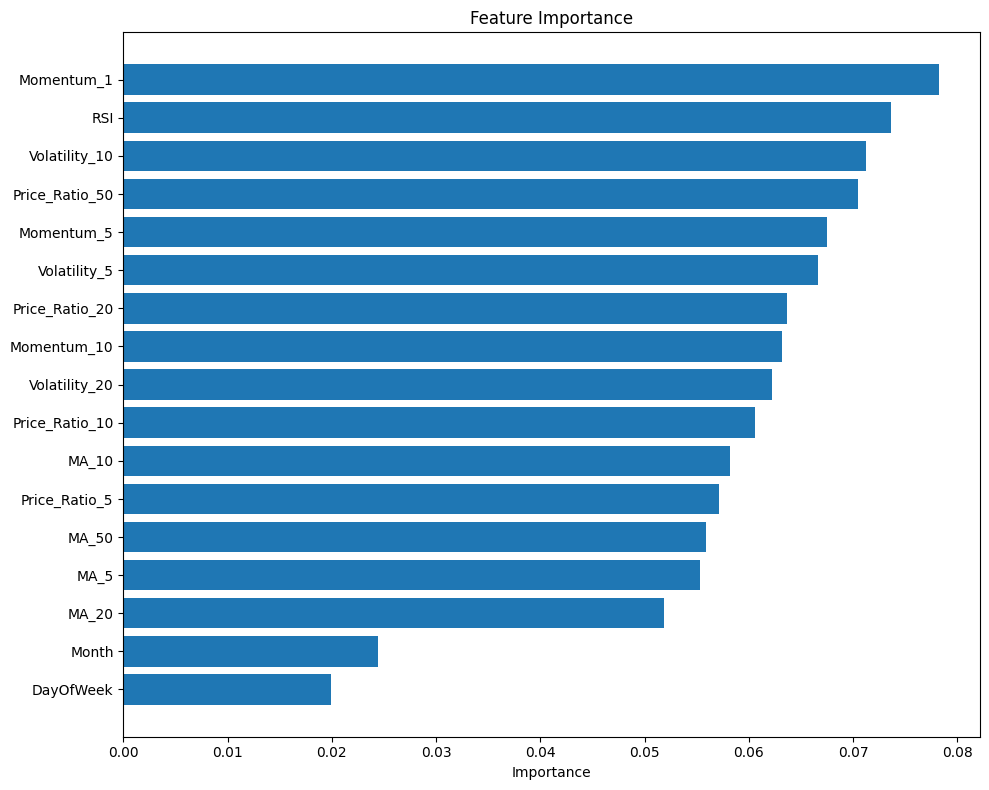

In [16]:
# Train a model on the full dataset to examine feature importance
full_model = RandomForestClassifier(n_estimators=100, min_samples_split=30, random_state=42)
full_model.fit(sp500_with_features[features], sp500_with_features['Target'])

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': full_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.tight_layout()
plt.show()

## 7. Model Improvement

Let's experiment with adjusting the prediction threshold to improve our precision.

In [17]:
def predict_with_threshold(train, test, features, model, threshold=0.5):
    """Train model and predict with a custom probability threshold"""
    model.fit(train[features], train['Target'])
    proba = model.predict_proba(test[features])[:, 1]  # Probability of the positive class
    preds = (proba >= threshold).astype(int)
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

def backtest_with_threshold(data, model, features, threshold=0.5, start=500, step=250):
    """Walk-forward testing with custom threshold"""
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict_with_threshold(train, test, features, model, threshold)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [18]:
# Try different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
results = []

for threshold in thresholds:
    model = RandomForestClassifier(n_estimators=100, min_samples_split=30, random_state=42)
    predictions = backtest_with_threshold(sp500_with_features, model, features, threshold)
    
    # Calculate metrics
    precision = precision_score(predictions['Target'], predictions['Predictions'])
    recall = recall_score(predictions['Target'], predictions['Predictions'])
    f1 = f1_score(predictions['Target'], predictions['Predictions'])
    
    # Count predictions
    num_predictions = predictions['Predictions'].sum()
    pct_predicted_up = num_predictions / len(predictions)
    
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'num_predictions': num_predictions,
        'pct_predicted_up': pct_predicted_up
    })

# Display results
results_df = pd.DataFrame(results)
results_df

,threshold,precision,recall,f1,num_predictions,pct_predicted_up
0,0.3,0.539877,0.900465,0.675035,1793,0.911540
1,0.4,0.547323,0.817674,0.655725,1606,0.816472
2,0.5,0.542952,0.605581,0.572559,1199,0.609558
3,0.6,0.537288,0.294884,0.380781,590,0.299949
4,0.7,0.565476,0.088372,0.152856,168,0.085409


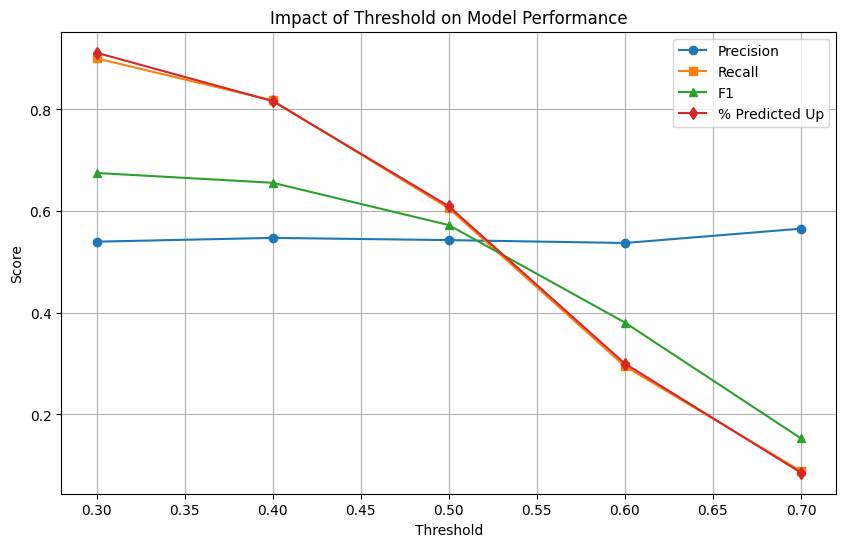

In [19]:
# Visualize the threshold impact
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['precision'], marker='o', label='Precision')
plt.plot(results_df['threshold'], results_df['recall'], marker='s', label='Recall')
plt.plot(results_df['threshold'], results_df['f1'], marker='^', label='F1')
plt.plot(results_df['threshold'], results_df['pct_predicted_up'], marker='d', label='% Predicted Up')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Impact of Threshold on Model Performance')
plt.grid(True)
plt.legend()
plt.show()

## 8. Conclusion

In this notebook, we've built a Random Forest model to predict the next-day directional movement of the S&P 500 index. 

Key findings:
1. Our model achieves a precision of 54.3%, meaning when it predicts the market will go up, it's correct 54.3% of the time.
2. The most important features are Momentum_1, RSI, Volatility_10, Price_Ratio_50, and Momentum_5, indicating that recent price action and volatility are strong predictors of market direction.
3. By adjusting the threshold to 0,7, we can achieve a higher precision of 56.5% at the cost of making fewer predictions (only predicting "up" for 8% of trading days).

Further improvements could include:
1. Adding more external data sources (economic indicators, sentiment analysis)
2. Testing different machine learning algorithms
3. More sophisticated feature engineering
4. Hyperparameter optimization